## Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from datetime import date
from functools import reduce
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from scipy.stats import boxcox
import seaborn as sns

## Read Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/superstore.csv', encoding='cp1252')
pd.set_option('display.max_columns', None)
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## Data Preprocessing

In [ ]:
data = data.drop(["Row ID", "Ship Date", "Ship Mode", "Customer Name", "Country", "State", "Postal Code", "Region", "Sub-Category", "Product Name", "Discount", "Profit"], axis=1)
data.head()

,Order ID,Order Date,Customer ID,Segment,City,Product ID,Category,Sales,Quantity
0,CA-2016-152156,11/8/2016,CG-12520,Consumer,Henderson,FUR-BO-10001798,Furniture,261.9600,2
1,CA-2016-152156,11/8/2016,CG-12520,Consumer,Henderson,FUR-CH-10000454,Furniture,731.9400,3
2,CA-2016-138688,6/12/2016,DV-13045,Corporate,Los Angeles,OFF-LA-10000240,Office Supplies,14.6200,2
3,US-2015-108966,10/11/2015,SO-20335,Consumer,Fort Lauderdale,FUR-TA-10000577,Furniture,957.5775,5
4,US-2015-108966,10/11/2015,SO-20335,Consumer,Fort Lauderdale,OFF-ST-10000760,Office Supplies,22.3680,2


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Order ID     9994 non-null   object 
 1   Order Date   9994 non-null   object 
 2   Customer ID  9994 non-null   object 
 3   Segment      9994 non-null   object 
 4   City         9994 non-null   object 
 5   Product ID   9994 non-null   object 
 6   Category     9994 non-null   object 
 7   Sales        9994 non-null   float64
 8   Quantity     9994 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 702.8+ KB


In [ ]:
print("Jumlah duplikasi data : " + str(data.duplicated().sum()))

Jumlah duplikasi data : 1


In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
negative_sales = data[data["Sales"] < 0]
negative_sales.head()

,Order ID,Order Date,Customer ID,Segment,City,Product ID,Category,Sales,Quantity


In [ ]:
negative_quantity = data[data["Quantity"] < 0]
negative_quantity.head()

,Order ID,Order Date,Customer ID,Segment,City,Product ID,Category,Sales,Quantity


## Feature Engineering

### Days Since Last Purchased (R)

In [ ]:
# Convert to datetime object
data['Order Date'] = pd.to_datetime(data['Order Date'])

last_purchased_date = data.groupby(["Customer ID"], as_index=False)['Order Date'].max()

max_date = data['Order Date'].max() + pd.Timedelta(3, "d")
last_purchased_date['Days Since Last Purchased'] = (max_date - last_purchased_date['Order Date']).dt.days
last_purchased_date.sort_values(by='Days Since Last Purchased', ascending=True)
last_purchased_date = last_purchased_date.drop(['Order Date'], axis=1)
last_purchased_date

,Customer ID,Days Since Last Purchased
0,AA-10315,187
1,AA-10375,22
2,AA-10480,262
3,AA-10645,58
4,AB-10015,418
...,...,...
788,XP-21865,46
789,YC-21895,7
790,YS-21880,12
791,ZC-21910,57


### Total frequency transaction (F)

In [ ]:
total_transaction = data.groupby('Customer ID')['Order ID'].nunique()
total_transaction = total_transaction.to_frame().reset_index()
total_transaction.columns = ['Customer ID', 'Total Transaction']
total_transaction

,Customer ID,Total Transaction
0,AA-10315,5
1,AA-10375,9
2,AA-10480,4
3,AA-10645,6
4,AB-10015,3
...,...,...
788,XP-21865,11
789,YC-21895,5
790,YS-21880,8
791,ZC-21910,13


### Average Sales (M)

In [ ]:
total_spend_per_transaction = data.groupby(['Customer ID'], as_index=False)['Sales'].sum()

average_transaction = pd.merge(total_transaction, total_spend_per_transaction, on='Customer ID')
average_transaction['Average Sales'] = average_transaction['Sales'] / average_transaction['Total Transaction']
average_transaction.columns = ['Customer ID', 'Total Transaction', 'Total Spend', 'Average Spend']
average_transaction

,Customer ID,Total Transaction,Total Spend,Average Spend
0,AA-10315,5,5563.560,1112.712000
1,AA-10375,9,1056.390,117.376667
2,AA-10480,4,1790.512,447.628000
3,AA-10645,6,5086.935,847.822500
4,AB-10015,3,886.156,295.385333
...,...,...,...,...
788,XP-21865,11,2374.658,215.878000
789,YC-21895,5,5454.350,1090.870000
790,YS-21880,8,6720.444,840.055500
791,ZC-21910,13,8025.707,617.362077


### Average days between purchases

In [ ]:
customer_order = data.groupby(['Customer ID', 'Order ID'], as_index=False)['Order Date'].max()
customer_order.sort_values(by = 'Order Date', inplace=True)
customer_order['Days Between Orders'] = customer_order.groupby(['Customer ID'])['Order Date'].diff().dt.days
avg_days_between_orders = customer_order.groupby(['Customer ID'], as_index=False)['Days Between Orders'].mean()
avg_days_between_orders.columns = ['Customer ID', 'Average days between order']

avg_days_between_orders

,Customer ID,Average days between order
0,AA-10315,296.500000
1,AA-10375,166.250000
2,AA-10480,359.000000
3,AA-10645,246.400000
4,AB-10015,498.000000
...,...,...
788,XP-21865,139.700000
789,YC-21895,283.750000
790,YS-21880,153.428571
791,ZC-21910,93.333333


### Merge data

In [ ]:
dataframes = [last_purchased_date, average_transaction]

merged_data = reduce(lambda left, right: pd.merge(left, right, on='Customer ID', how='outer'), dataframes)
merged_data

,Customer ID,Days Since Last Purchased,Total Transaction,Total Spend,Average Spend
0,AA-10315,187,5,5563.560,1112.712000
1,AA-10375,22,9,1056.390,117.376667
2,AA-10480,262,4,1790.512,447.628000
3,AA-10645,58,6,5086.935,847.822500
4,AB-10015,418,3,886.156,295.385333
...,...,...,...,...,...
788,XP-21865,46,11,2374.658,215.878000
789,YC-21895,7,5,5454.350,1090.870000
790,YS-21880,12,8,6720.444,840.055500
791,ZC-21910,57,13,8025.707,617.362077


## EDA

<ipython-input-17-02409b3dfc24>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_data[x] , bins = 20)
<ipython-input-17-02409b3dfc24>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_data[x] , bins = 20)
<ipython-input-17-02409b3dfc24>:8: UserWarning: 

`distplot` is a deprecated f

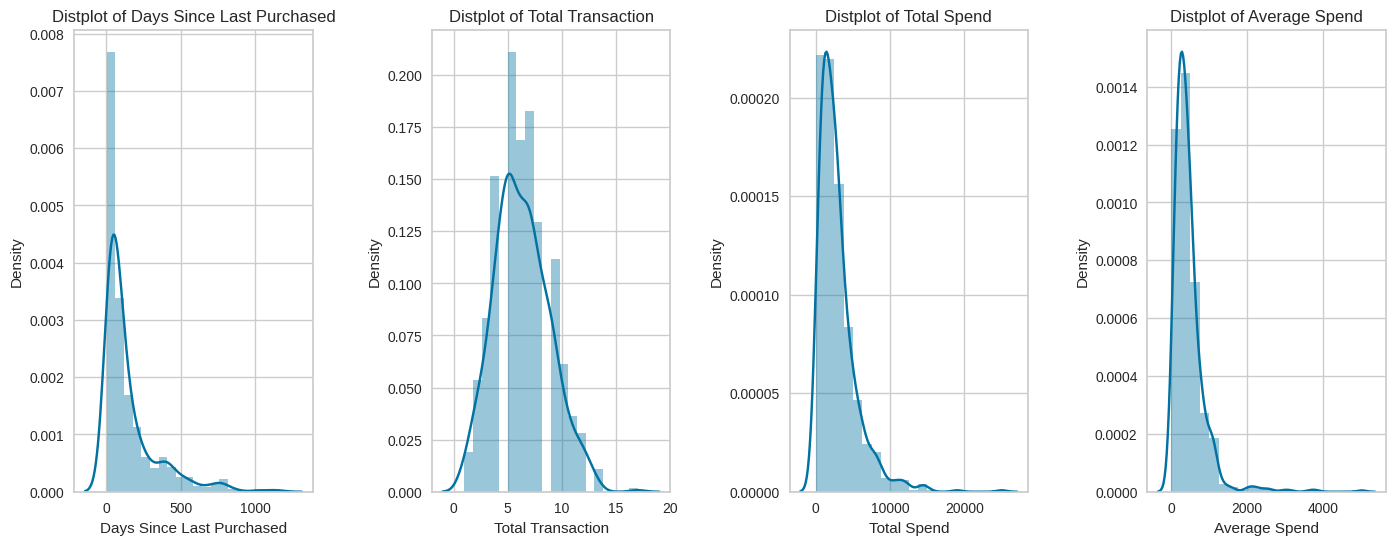

In [ ]:
plt.figure(1 , figsize = (40 , 6))
n = 0
for x in ['Days Since Last Purchased',
       'Total Transaction', 'Total Spend', 'Average Spend']:
    n += 1
    plt.subplot(1 , 9 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(merged_data[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

## Feature Scaling

In [ ]:
scaler = StandardScaler()
normalize = MinMaxScaler()

exclude_col = ['Customer ID']
col_to_scale = merged_data.columns.difference(exclude_col)
merged_data_scaled = merged_data.copy()
merged_data_scaled[col_to_scale] = normalize.fit_transform(merged_data_scaled[col_to_scale])
merged_data_scaled = pd.DataFrame(merged_data_scaled, columns=merged_data.columns)
merged_data_scaled

,Customer ID,Days Since Last Purchased,Total Transaction,Total Spend,Average Spend
0,AA-10315,0.157940,0.2500,0.222010,0.221784
1,AA-10375,0.016309,0.5000,0.041998,0.022964
2,AA-10480,0.222318,0.1875,0.071318,0.088932
3,AA-10645,0.047210,0.3125,0.202974,0.168872
4,AB-10015,0.356223,0.1250,0.035199,0.058521
...,...,...,...,...,...
788,XP-21865,0.036910,0.6250,0.094648,0.042639
789,YC-21895,0.003433,0.2500,0.217648,0.217421
790,YS-21880,0.007725,0.4375,0.268214,0.167321
791,ZC-21910,0.046352,0.7500,0.320345,0.122837


## Feature Selection

In [ ]:
merged_data_scaled.set_index('Customer ID', inplace=True)

In [ ]:
corr = merged_data_scaled.corr()

In [ ]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
upper

,Days Since Last Purchased,Total Transaction,Total Spend,Average Spend
Days Since Last Purchased,NaN,-0.384015,-0.142626,0.013029
Total Transaction,NaN,NaN,0.417666,-0.008838
Total Spend,NaN,NaN,NaN,0.841782
Average Spend,NaN,NaN,NaN,NaN


In [ ]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

[]

In [ ]:
merged_data_scaled.drop(merged_data_scaled[to_drop], axis=1, inplace=True)

## K-Means Clustering

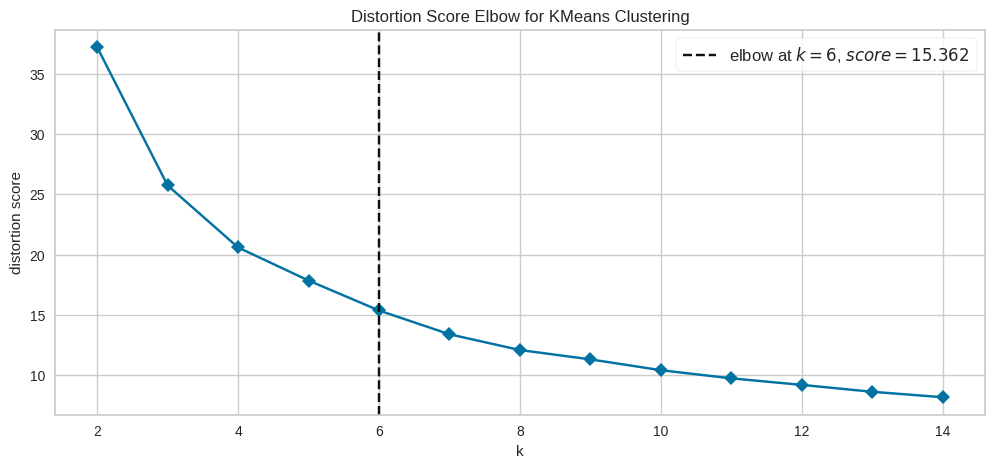

In [ ]:
clusterer = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)
fig, ax = plt.subplots(figsize=(12, 5))
visualizer = KElbowVisualizer(clusterer, k=(2, 15), timings=False, ax=ax)
visualizer.fit(merged_data_scaled)
visualizer.show();

For n_clusters = 2 The average silhouette_coefficient is : 0.3242019255834053
For n_clusters = 3 The average silhouette_coefficient is : 0.34738117440965904
For n_clusters = 4 The average silhouette_coefficient is : 0.36184173354077753
For n_clusters = 5 The average silhouette_coefficient is : 0.29026264334865465
For n_clusters = 6 The average silhouette_coefficient is : 0.30501773819212785
For n_clusters = 7 The average silhouette_coefficient is : 0.3044094330100351
For n_clusters = 8 The average silhouette_coefficient is : 0.3015058822653494
For n_clusters = 9 The average silhouette_coefficient is : 0.2941390759000614
For n_clusters = 10 The average silhouette_coefficient is : 0.2862464013383424
For n_clusters = 11 The average silhouette_coefficient is : 0.2686558219053599
For n_clusters = 12 The average silhouette_coefficient is : 0.27683071079369204
For n_clusters = 13 The average silhouette_coefficient is : 0.28297728889388146
For n_clusters = 14 The average silhouette_coefficient

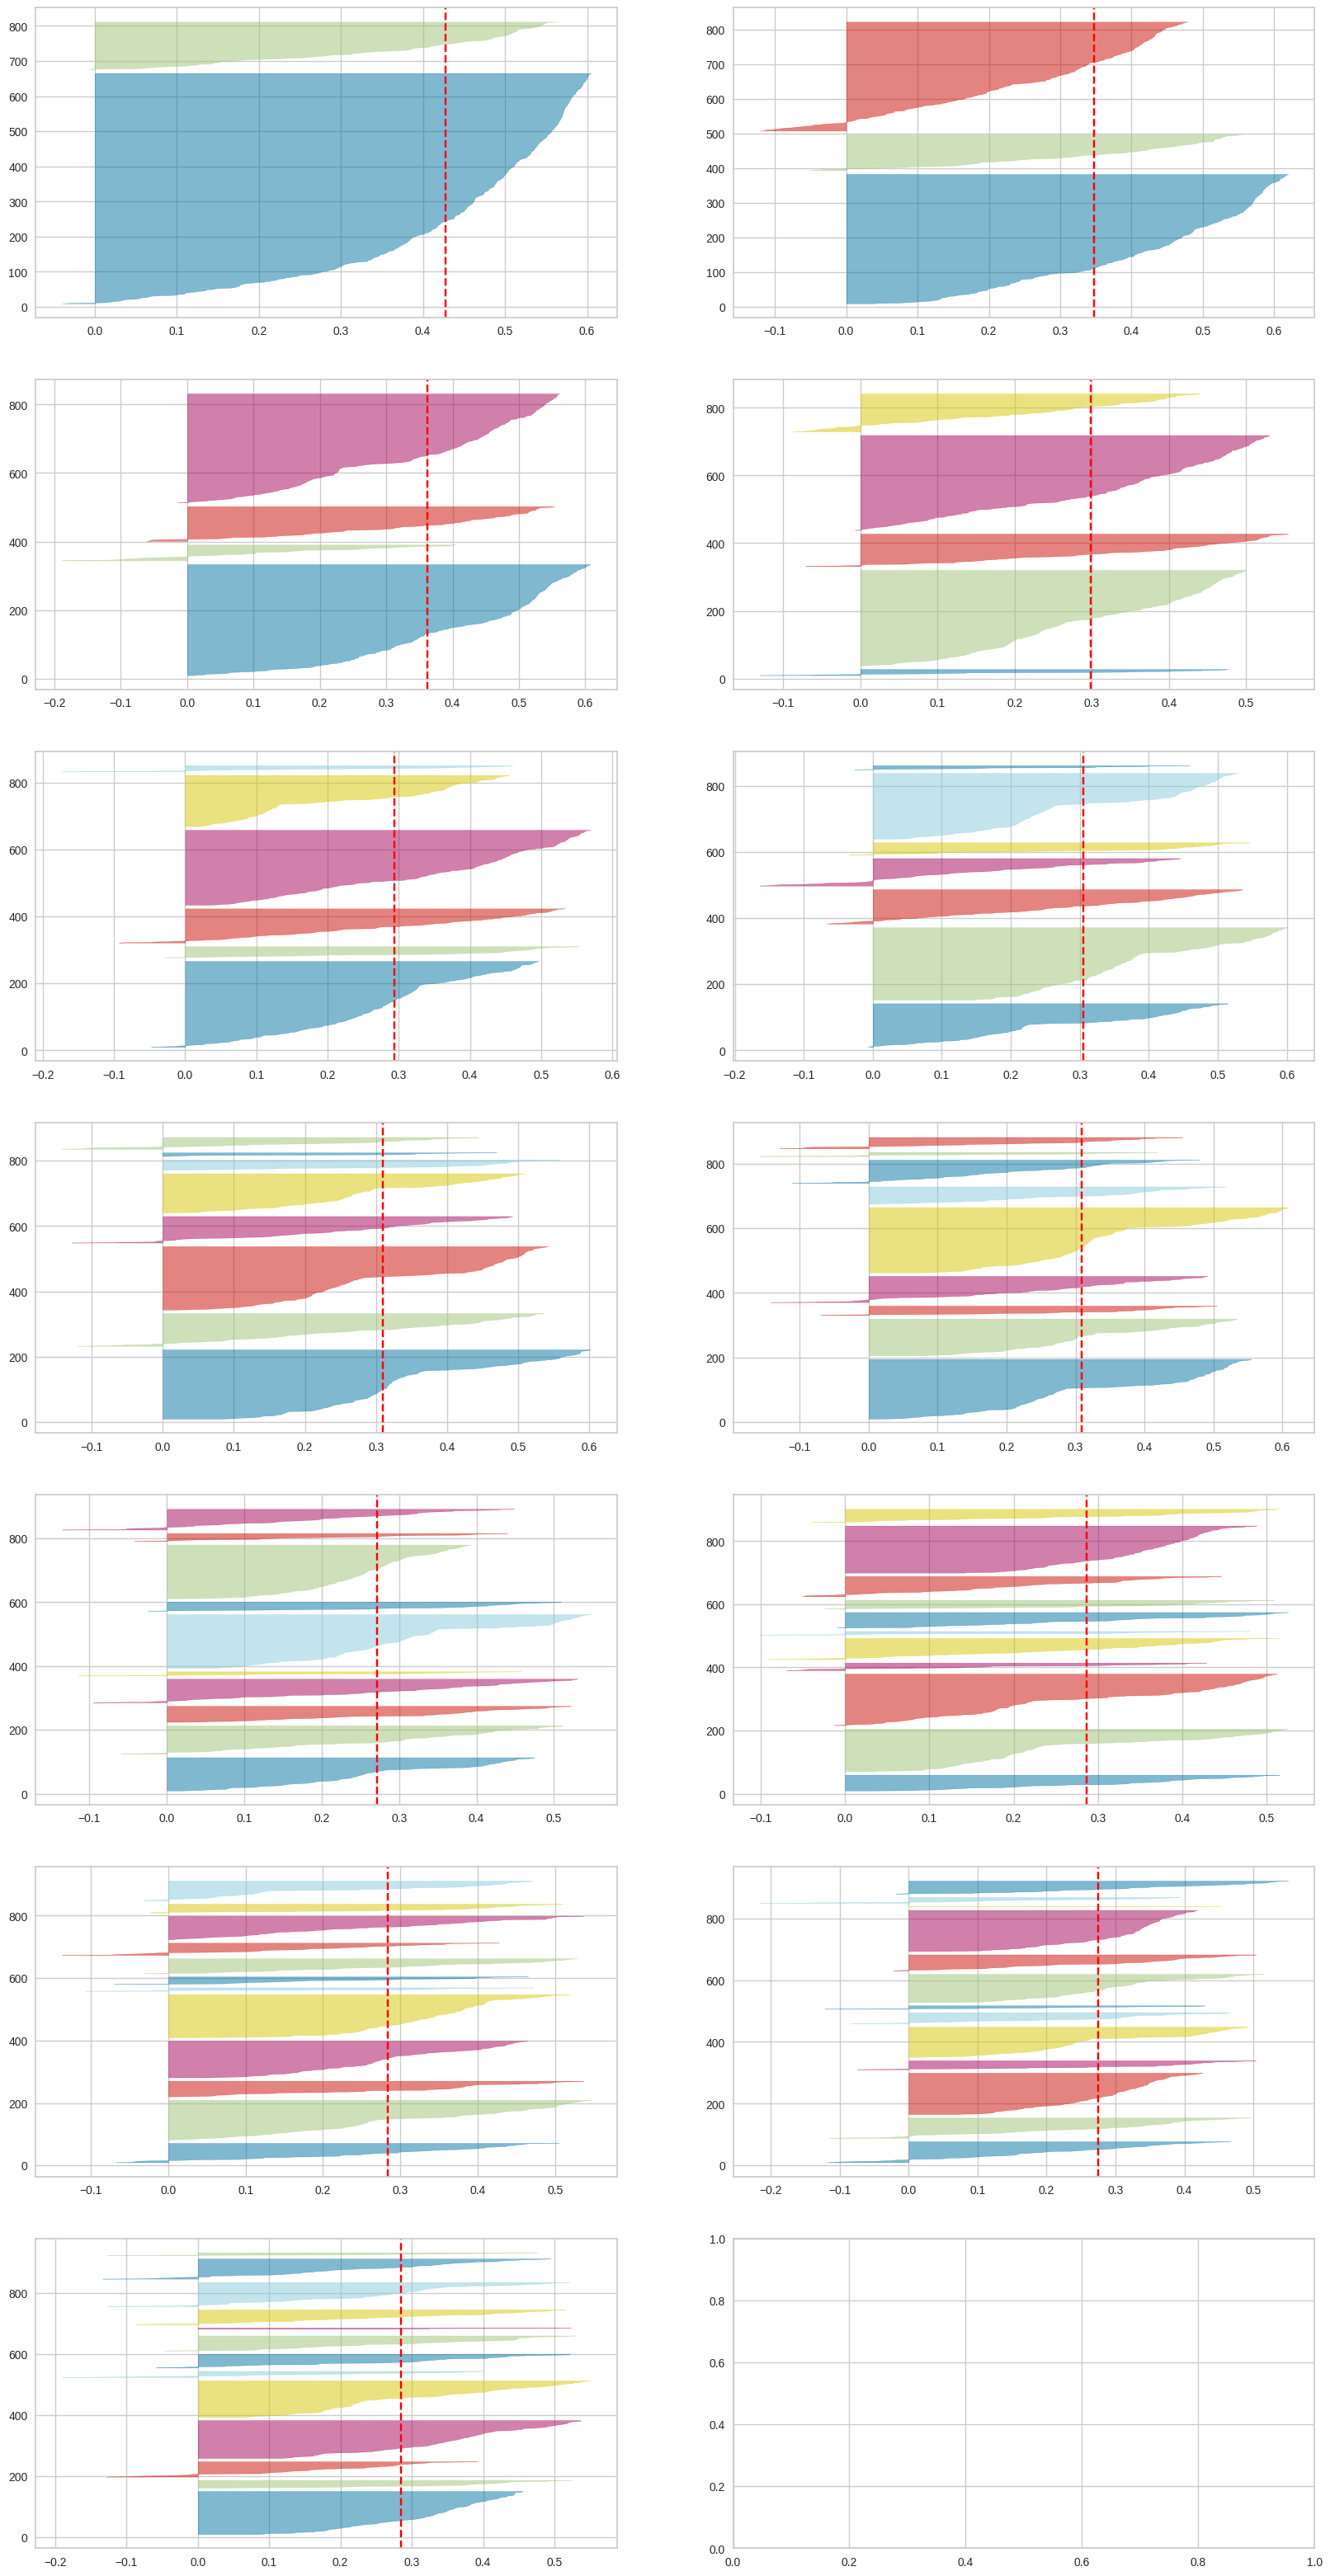

In [ ]:
num_of_cluster = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

fig, ax = plt.subplots(7, 2, figsize=(20,40))
for k in num_of_cluster:
    clusterer = KMeans(n_clusters = k, n_init=10)

    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(clusterer, colors = 'yellowbrick', ax = ax[q-1][mod])
    visualizer.fit(merged_data_scaled)

    cluster_labels = clusterer.fit_predict(merged_data_scaled)
    silhouette_avg = silhouette_score(merged_data_scaled, cluster_labels)
    print(
        "For n_clusters =",
        k,
        "The average silhouette_coefficient is :",
        silhouette_avg,
    )

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(merged_data_scaled)
cluster_labels = kmeans.labels_
merged_data['Cluster'] = cluster_labels

In [ ]:
merged_data.head(10)

,Customer ID,Days Since Last Purchased,Total Transaction,Total Spend,Average Spend,Cluster
0,AA-10315,187,5,5563.560,1112.712000,3
1,AA-10375,22,9,1056.390,117.376667,2
2,AA-10480,262,4,1790.512,447.628000,3
3,AA-10645,58,6,5086.935,847.822500,3
4,AB-10015,418,3,886.156,295.385333,1
5,AB-10060,57,8,7755.620,969.452500,0
6,AB-10105,44,10,14473.571,1447.357100,0
7,AB-10150,44,5,966.710,193.342000,3
8,AB-10165,28,8,1113.838,139.229750,2
9,AB-10255,169,9,914.532,101.614667,2


<ipython-input-28-38967d07bdb0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)


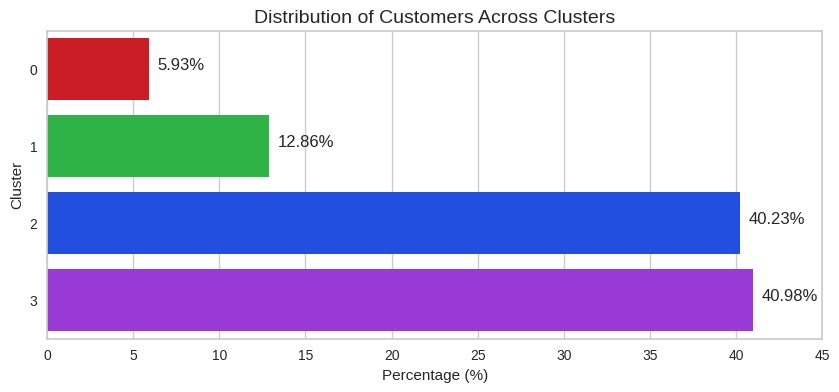

In [ ]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff','#A020F0']

# Calculate the percentage of customers in each cluster
cluster_percentage = (merged_data['Cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

# Reference: https://www.kaggle.com/code/farzadnekouei/customer-segmentation-recommendation-system/notebook#Step-10.1-|--3D-Visualization-of-Top-Principal-Components

In [ ]:
merged_data.groupby(["Cluster"])['Days Since Last Purchased'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,47.0,122.063830,125.883902,9.0,44.50,72.0,152.00,561.0
1,102.0,550.294118,192.801370,302.0,408.25,486.0,683.75,1168.0
2,319.0,74.288401,75.187595,3.0,25.00,46.0,100.00,413.0
3,325.0,102.240000,82.973357,3.0,37.00,79.0,140.00,352.0


In [ ]:
merged_data.groupby(["Cluster"])['Total Transaction'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,47.0,7.021277,2.444954,2.0,5.5,7.0,8.0,12.0
1,102.0,3.813725,1.584144,1.0,3.0,4.0,5.0,7.0
2,319.0,8.667712,1.626024,7.0,7.0,8.0,9.0,17.0
3,325.0,4.692308,1.243788,1.0,4.0,5.0,6.0,7.0


In [ ]:
merged_data.groupby(["Cluster"])['Total Spend'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,47.0,10060.099523,3674.811955,5253.8760,7738.34500,9133.9900,11804.8750,25043.050
1,102.0,1584.846458,1519.292838,4.8330,470.79075,1265.0840,2152.9565,9062.864
2,319.0,3451.394149,1755.697133,644.1188,2184.86850,3127.9592,4517.0665,8697.843
3,325.0,1727.525349,1251.256797,16.7390,797.83200,1395.9380,2454.9280,5690.055


In [ ]:
merged_data.groupby(["Cluster"])['Average Spend'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,47.0,1614.109828,891.851051,859.240000,1071.527848,1181.269083,1999.306917,5008.610000
1,102.0,404.382640,342.425077,2.416500,143.001700,344.718567,530.385000,2265.716000
2,319.0,401.040604,194.103581,85.521375,248.586714,361.701111,533.763222,906.443286
3,325.0,368.676424,258.238315,11.164000,172.122000,315.503500,503.623000,1249.222667


In [ ]:
import pickle
with open("kmeans.pkl", "wb") as f:
    pickle.dump(kmeans, f, protocol=5)